Imports + env

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    if rng.random() < epsilon:
        return int(rng.integers(n_actions))
    return int(np.argmax(Q[state]))

def moving_average(x, window=200):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

In [3]:
def train_sarsa(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        action = epsilon_greedy(Q, state, n_actions, epsilon, rng)

        total_reward = 0.0

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            next_action = epsilon_greedy(Q, next_state, n_actions, epsilon, rng)

            td_target = reward + (0.0 if done else gamma * Q[next_state, next_action])
            Q[state, action] += alpha * (td_target - Q[state, action])

            state, action = next_state, next_action
            if done:
                break

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 1000 == 0:
            print(f"Episode {ep+1:>6} | eps={epsilon:.3f} | avg(last1000)={np.mean(rewards_history[-1000:]):.2f}")

    env.close()
    return Q, rewards_history


## Lancer Entraînement

In [4]:
Q, rewards = train_sarsa(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)

Episode   1000 | eps=0.606 | avg(last1000)=-532.04
Episode   2000 | eps=0.368 | avg(last1000)=-156.00
Episode   3000 | eps=0.223 | avg(last1000)=-32.41
Episode   4000 | eps=0.135 | avg(last1000)=-4.63
Episode   5000 | eps=0.082 | avg(last1000)=2.00
Episode   6000 | eps=0.050 | avg(last1000)=4.42
Episode   7000 | eps=0.050 | avg(last1000)=5.39
Episode   8000 | eps=0.050 | avg(last1000)=5.05
Episode   9000 | eps=0.050 | avg(last1000)=5.59
Episode  10000 | eps=0.050 | avg(last1000)=5.15
Episode  11000 | eps=0.050 | avg(last1000)=5.18
Episode  12000 | eps=0.050 | avg(last1000)=5.26
Episode  13000 | eps=0.050 | avg(last1000)=5.31
Episode  14000 | eps=0.050 | avg(last1000)=5.49
Episode  15000 | eps=0.050 | avg(last1000)=5.01
Episode  16000 | eps=0.050 | avg(last1000)=5.31
Episode  17000 | eps=0.050 | avg(last1000)=5.09
Episode  18000 | eps=0.050 | avg(last1000)=5.46
Episode  19000 | eps=0.050 | avg(last1000)=5.47
Episode  20000 | eps=0.050 | avg(last1000)=5.17


## Courbes d'apprentissage

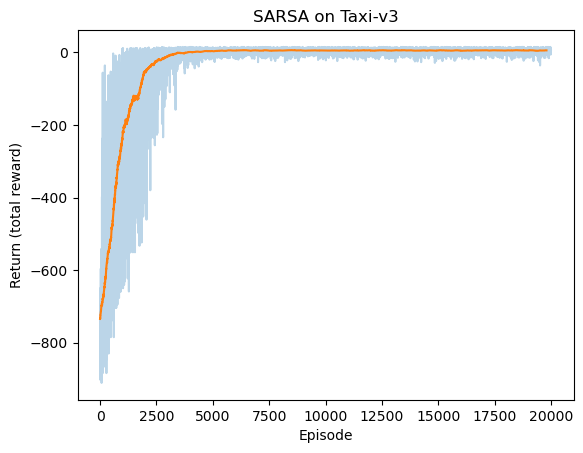

In [5]:
plt.figure()
plt.plot(rewards, alpha=0.3)
ma = moving_average(rewards, window=200)
plt.plot(range(len(ma)), ma)
plt.xlabel("Episode")
plt.ylabel("Return (total reward)")
plt.title("SARSA on Taxi-v3")
plt.show()

## Évaluation (politique greedy sans exploration)

In [6]:
def evaluate_greedy(env_id, Q, episodes=200, seed=123, max_steps=200):
    env = gym.make(env_id)
    returns = []

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        total = 0.0

        for _ in range(max_steps):
            action = int(np.argmax(Q[state]))
            state, reward, terminated, truncated, info = env.step(action)
            total += reward
            if terminated or truncated:
                break

        returns.append(total)

    env.close()
    return float(np.mean(returns)), float(np.std(returns))

mean_ret, std_ret = evaluate_greedy("Taxi-v3", Q, episodes=200)
mean_ret, std_ret


(7.88, 2.6693819509392056)